# **Text Classification (Multi-label)**

# Install&Import

In [ ]:
!pip install --upgrade pythainlp
!pip install stop_words
!pip install deepcut
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# สำหรับการจัดการข้อมูล
import pandas as pd
import numpy as np
import re

# สำหรับการจัดการข้อความภาษาไทย
import pythainlp
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
from pythainlp.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words
import nltk
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

# สำหรับการทำ Model
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, make_scorer
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# สำหรับการแสดงผลในรูปแบบแผนภาพ
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
plt.rc('font', family='TH Sarabun New', size=10)

In [ ]:
nltk.download('words')
nltk.download('omw-1.4')
th_stop = tuple(thai_stopwords())
en_stop = tuple(get_stop_words('en'))
p_stemmer = PorterStemmer()

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Load Data

In [ ]:
traffy = pd.read_csv("/content/traffy_assignment_unique.csv")

In [ ]:
# จำนวนของแต่ละประเภทปัญหาที่ถูกร้องเรียน
counts = []
problem = list(traffy.columns.values)
for i in problem[2:]:
  counts.append((i, traffy[i].sum()))
problem = pd.DataFrame(counts, columns = ["ปัญหา", "จำนวน"])
problem

,ปัญหา,จำนวน
0,การเดินทาง,119
1,กีดขวาง,1044
2,คนจรจัด,94
3,คลอง,95
4,ความปลอดภัย,1782
5,ความสะอาด,548
6,จราจร,965
7,ต้นไม้,394
8,ถนน,1212
9,ทางเท้า,1001


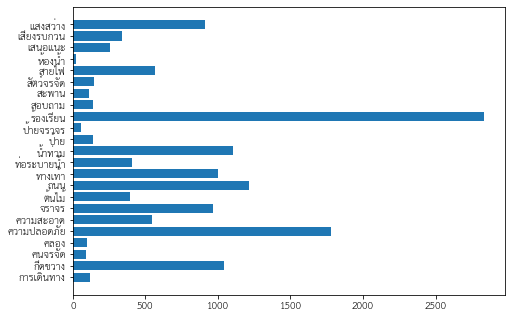

In [ ]:
# แสดงผลลัพธ์ของจำนวนของปัญหาแต่ละประเภท
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = problem['ปัญหา']
students = problem['จำนวน']
ax.barh(langs,students)
plt.show()

จะเห็นได้จากผลลัพธ์ที่กราฟแสดงให้เห็นจำนวนของปัญหาที่ถูกร้องเรียนของปัญหาแต่ละประเภท ชุดข้อมูลนี้นั้น Imbalanced อาจส่งผลให้ขั้นตอนของการทำนายนั้นผิดพลาดได้เพราะจำนวนของแต่ละ class นั้นแตกต่างกันอย่างมาก ดังนั้นจึงต้องดูประสิทธิภาพของ model ด้วยหลาย ๆ ค่าวัดประกอบกัน ซึ่งในการทำ Classification นั้นจะให้น้ำหนักในส่วนของ weighted average เป็นหลัก

# Text Cleaning

In [ ]:
# สร้าง function สำหรับการลบตัวอักษรที่ไม่ต้องการออกไป
def clean_msg(msg):
  
  # ลบ emojiและตัวอักษรที่ไม่ต้องการ
  emoj = re.compile("["
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U00002600-\U000026FF"  # Miscellaneous Symbols
        u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols And Pictographs
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
        "]+", re.UNICODE)
  msg = re.sub(emoj, '', msg)
  msg = re.sub(r'<.*?>','', msg)
  msg = re.sub('[^ก-์]+', '', msg)
  msg = re.sub(r'#','',msg)

  All_punct = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  for elements in msg:
    if elements in All_punct:
      msg = msg.replace(elements, "")
  # msg = ' '.join(msg.split())

  return msg

In [ ]:
# ใช้ clean function กับข้อความร้องเรียน
traffy_clean = [clean_msg(txt) for txt in traffy.issues]

# Tokenization

In [ ]:
# สร้าง tokenization function เพื่อจัดการกับข้อความร้องเรียน
def token_word(text):

    # สร้าง token          
    tokens = word_tokenize(text)

    # Thai
    tokens_temp=[]
    for i in tokens:
        w_syn = wordnet.synsets(i)
        if (len(w_syn)>0) and (len(w_syn[0].lemma_names('tha'))>0):
            tokens_temp.append(w_syn[0].lemma_names('tha')[0])
        else:
            tokens_temp.append(i)
    tokens = tokens_temp
    
    # ลบตัวเลข
    tokens = [i for i in tokens if not i.isnumeric()]
    
    # ลบช่องว่าง
    tokens = [i for i in tokens if not ' ' in i]

    tokens = [i for i in tokens if pythainlp.util.isthai(text)]

    return tokens

In [ ]:
# ใช้ tokenization function กับข้อความร้องเรียน
tokens_list = [token_word(txt) for txt in traffy_clean]

# TF-IDF

In [ ]:
# ถ่วงน้ำหนักคำ
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tokens_list_j = [','.join(tkn) for tkn in tokens_list]
tvec = TfidfVectorizer(analyzer=lambda x:x.split(','),)
tfidf = tvec.fit_transform(tokens_list_j)

# Test/Train Split

In [ ]:
X = tfidf.toarray()
y = np.asarray(traffy[traffy.columns[2:]])

In [ ]:
# แบ่งข้อมูลสำหรับการ train madel โดยกำหนดให้มี train data 70% และ test data 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# RandomForest



## Default

In [ ]:
# create a based model
rfc = RandomForestClassifier(random_state=42)

# fit model
rfc.fit(X_train, y_train)

# evaluating model
rfc_predicted = rfc.predict(X_test)
print(classification_report(y_test, rfc_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, rfc_predicted)*100))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.83      0.22      0.35       309
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00        23
           4       0.81      0.23      0.35       530
           5       0.61      0.22      0.32       143
           6       0.82      0.22      0.35       303
           7       0.96      0.19      0.32       119
           8       0.93      0.33      0.49       385
           9       0.87      0.36      0.51       292
          10       1.00      0.07      0.12       121
          11       0.97      0.79      0.87       320
          12       1.00      0.05      0.10        39
          13       0.00      0.00      0.00        16
          14       0.68      0.15      0.24       837
          15       0.00      0.00      0.00        39
          16       0.00      0.00      0.00        32
          17       1.00    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForest Default Parametre Model : ให้ค่าความถูกต้องอยู่ที่ 22.6232% และมีค่า weighted avg ของ f1-score อยู่ที่ 41% โดยประมาณ 



## Tuning

In [ ]:
# create a based model
rfc = RandomForestClassifier(random_state=42)

# create the parameter grid based on the results of random search
param_grid = {
    'max_features': ['sqrt'],
    'criterion' :['gini', 'entropy']
}

# instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid)

# fit the grid search to the data
grid_search.fit(X_train, y_train)

# get best estimator for voting classifier
rfc_best = grid_search.best_estimator_

# evaluating model
rfc_predicted = rfc_best.predict(X_test)
print(classification_report(y_test, rfc_predicted))
print('Best Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, rfc_predicted)*100))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.83      0.22      0.35       309
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00        23
           4       0.81      0.23      0.35       530
           5       0.61      0.22      0.32       143
           6       0.82      0.22      0.35       303
           7       0.96      0.19      0.32       119
           8       0.93      0.33      0.49       385
           9       0.87      0.36      0.51       292
          10       1.00      0.07      0.12       121
          11       0.97      0.79      0.87       320
          12       1.00      0.05      0.10        39
          13       0.00      0.00      0.00        16
          14       0.68      0.15      0.24       837
          15       0.00      0.00      0.00        39
          16       0.00      0.00      0.00        32
          17       1.00    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForest Tuning Parametre Model : ให้ค่าความถูกต้องอยู่ที่ 22.6232% และมีค่า weighted avg ของ f1-score อยู่ที่ 41% โดยประมาณ ซึ่งมีค่าเท่ากับ RandomForest Tuning Parametre Model นั้นแปลว่า Parametre ที่เลือกมา Tuning นั้นยังไม่เหมาะสมมากพอที่จะเพิ่มประสิทธิภาพของ Model

## Cross Validation

In [ ]:
# cross validation 5 folds
all_accuracy = cross_val_score(rfc_best, X, y, cv=5)
all_f1macro = cross_val_score(rfc_best, X, y, scoring="f1_macro", cv=5)
all_f1weighted = cross_val_score(rfc_best, X, y, scoring="f1_weighted", cv=5)
all_hamming = cross_val_score(rfc_best, X, y, scoring = make_scorer(hamming_loss,greater_is_better=False), cv=5)
print('Mean Accuracy = {:0.4f}%.'.format(all_accuracy.mean()*100))
print('Mean f1macro = {:0.4f}%.'.format(all_f1macro.mean()*100))
print('Mean f1weighted = {:0.4f}%.'.format(all_f1weighted.mean()*100))
print('Mean hamming = {:0.4f}%.'.format(all_hamming.mean()*100))

Mean Accuracy = 21.4929%.
Mean f1macro = 26.6089%.
Mean f1macro = 38.9399%.
Mean hamming = -5.4726%.


จากการแบ่งชุดข้อมูลออกเป็น 5 ส่วนและทำการ train ทุกชุดข้อมูลนั้น
พบว่าเมื่อเฉลี่ยค่าต่าง ๆ ที่สนใจแล้วนั้นเป็นดังข้างต้น ซึ่งคือประสิทธิภาพโดยรวมของ RandomForest Model

# DecisionTree

## Default

In [ ]:
# create a based model
dtc = DecisionTreeClassifier(random_state=42)

# fit model
dtc.fit(X_train, y_train)

# evaluating model
dtc_predicted = dtc.predict(X_test)
print(classification_report(y_test, dtc_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, dtc_predicted)*100))

              precision    recall  f1-score   support

           0       0.06      0.06      0.06        34
           1       0.51      0.51      0.51       309
           2       0.35      0.20      0.26        30
           3       0.24      0.22      0.23        23
           4       0.57      0.52      0.54       530
           5       0.51      0.51      0.51       143
           6       0.51      0.47      0.49       303
           7       0.63      0.65      0.64       119
           8       0.59      0.58      0.59       385
           9       0.72      0.68      0.70       292
          10       0.55      0.43      0.48       121
          11       0.87      0.88      0.87       320
          12       0.47      0.46      0.47        39
          13       0.00      0.00      0.00        16
          14       0.40      0.39      0.40       837
          15       0.26      0.18      0.21        39
          16       0.17      0.16      0.16        32
          17       0.71    

DecisionTree Default Parametre Model : ให้ค่าความถูกต้องอยู่ที่ 26.4261% และมีค่า weighted avg ของ f1-score อยู่ที่ 55% โดยประมาณ

## Tuning

In [ ]:
# create a based model
dtc = DecisionTreeClassifier(random_state=42)

# create the parameter grid based on the results of random search
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']}

# instantiate the grid search model
grid_search = GridSearchCV(estimator = dtc, param_grid = param_grid)

# fit the grid search to the data
grid_search.fit(X_train, y_train)

# get best estimator for voting classifier
dtc_best = grid_search.best_estimator_

# evaluating model
dtc_predicted = dtc_best.predict(X_test)
print(classification_report(y_test, dtc_predicted))
print('Best Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, dtc_predicted)*100))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.00      0.00      0.00       309
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00       530
           5       0.00      0.00      0.00       143
           6       0.00      0.00      0.00       303
           7       0.00      0.00      0.00       119
           8       0.60      0.05      0.09       385
           9       0.00      0.00      0.00       292
          10       0.00      0.00      0.00       121
          11       0.46      0.05      0.09       320
          12       0.00      0.00      0.00        39
          13       0.00      0.00      0.00        16
          14       0.46      0.02      0.04       837
          15       0.00      0.00      0.00        39
          16       0.00      0.00      0.00        32
          17       0.56    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTree Tuning Parametre Model : ให้ค่าความถูกต้องอยู่ที่ 3.3372% และมีค่า weighted avg ของ f1-score อยู่ที่ 7% โดยประมาณ นั้นแปลว่า Parametre ที่เลือกมา Tuningนั้นไม่เหมาะสมกับชุดข้อมูลทำให้ลดประสิทธิภาพของ Model ลง

## Cross Validation

In [ ]:
# cross validation 5 folds
all_accuracy = cross_val_score(dtc_best, X, y, cv=5)
all_f1macro = cross_val_score(dtc_best, X, y, scoring="f1_macro", cv=5)
all_f1weighted = cross_val_score(dtc_best, X, y, scoring="f1_weighted", cv=5)
all_hamming = cross_val_score(dtc_best, X, y, scoring = make_scorer(hamming_loss,greater_is_better=False), cv=5)
print('Mean Accuracy = {:0.4f}%.'.format(all_accuracy.mean()*100))
print('Mean f1macro = {:0.4f}%.'.format(all_f1macro.mean()*100))
print('Mean f1weighted = {:0.4f}%.'.format(all_f1weighted.mean()*100))
print('Mean hamming = {:0.4f}%.'.format(all_hamming.mean()*100))

Mean Accuracy = 3.3878%.
Mean f1macro = 7.2714%.
Mean f1macro = 7.7598%.
Mean hamming = -6.9513%.


จากการแบ่งชุดข้อมูลออกเป็น 5 ส่วนและทำการ train ทุกชุดข้อมูลนั้น พบว่าเมื่อเฉลี่ยค่าต่าง ๆ ที่สนใจแล้วนั้นเป็นดังข้างต้น ซึ่งคือประสิทธิภาพโดยรวมของ DecisionTree Model

# KNN

## Default

In [ ]:
# create a based model
knn = KNeighborsClassifier()

# fit model
knn.fit(X_train, y_train)

# evaluating model
knn_predicted = knn.predict(X_test)
print(classification_report(y_test, knn_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, knn_predicted)*100))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.74      0.48      0.58       309
           2       0.89      0.27      0.41        30
           3       0.22      0.09      0.12        23
           4       0.58      0.30      0.40       530
           5       0.58      0.35      0.44       143
           6       0.63      0.37      0.47       303
           7       0.77      0.37      0.50       119
           8       0.71      0.37      0.49       385
           9       0.75      0.44      0.56       292
          10       0.65      0.29      0.40       121
          11       0.80      0.76      0.78       320
          12       1.00      0.28      0.44        39
          13       0.50      0.12      0.20        16
          14       0.43      0.29      0.34       837
          15       0.33      0.03      0.05        39
          16       0.50      0.16      0.24        32
          17       0.90    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNN Default Parametre Model : ให้ค่าความถูกต้องอยู่ที่ 22.1187% และมีค่า weighted avg ของ f1-score อยู่ที่ 48% โดยประมาณ

## Tuning

In [ ]:
# create a based model
knn = KNeighborsClassifier()

# create the parameter grid based on the results of random search
param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# instantiate the grid search model
grid_search = GridSearchCV(estimator = knn, param_grid = param_grid)

# fit the grid search to the data
grid_search.fit(X_train, y_train)

# get best estimator for voting classifier
knn_best = grid_search.best_estimator_

# evaluating model
knn_predicted = knn_best.predict(X_test)
print(classification_report(y_test, knn_predicted))
print('Best Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, knn_predicted)*100))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.72      0.45      0.55       309
           2       0.67      0.07      0.12        30
           3       0.29      0.09      0.13        23
           4       0.62      0.28      0.38       530
           5       0.62      0.35      0.45       143
           6       0.68      0.35      0.46       303
           7       0.87      0.38      0.53       119
           8       0.79      0.37      0.51       385
           9       0.78      0.39      0.52       292
          10       0.73      0.29      0.41       121
          11       0.87      0.77      0.82       320
          12       0.91      0.26      0.40        39
          13       1.00      0.06      0.12        16
          14       0.46      0.26      0.33       837
          15       1.00      0.03      0.05        39
          16       0.50      0.16      0.24        32
          17       0.87    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNN Tuning Parametre Model : ให้ค่าความถูกต้องอยู่ที่ 22.5068% และมีค่า weighted avg ของ f1-score อยู่ที่ 48% โดยประมาณ นั้นแปลว่า Parametre ที่เลือกมา Tuning สามารถเพิ่มประสิทธิภาพของ Model ได้เล็กน้อย

## Cross Validation

In [ ]:
# cross validation 5 folds
all_accuracy = cross_val_score(knn_best, X, y, cv=5)
all_f1macro = cross_val_score(knn_best, X, y, scoring="f1_macro", cv=5)
all_f1weighted = cross_val_score(knn_best, X, y, scoring="f1_weighted", cv=5)
all_hamming = cross_val_score(knn_best, X, y, scoring = make_scorer(hamming_loss,greater_is_better=False), cv=5)
print('Mean Accuracy = {:0.4f}%.'.format(all_accuracy.mean()*100))
print('Mean f1macro = {:0.4f}%.'.format(all_f1macro.mean()*100))
print('Mean f1weighted = {:0.4f}%.'.format(all_f1weighted.mean()*100))
print('Mean hamming = {:0.4f}%.'.format(all_hamming.mean()*100))

Mean Accuracy = 20.5263%.
Mean f1macro = 37.4259%.
Mean f1macro = 46.0316%.
Mean hamming = -5.7966%.


จากการแบ่งชุดข้อมูลออกเป็น 5 ส่วนและทำการ train ทุกชุดข้อมูลนั้น พบว่าเมื่อเฉลี่ยค่าต่าง ๆ ที่สนใจแล้วนั้นเป็นดังข้างต้น ซึ่งคือประสิทธิภาพโดยรวมของ KNN Model

# Summary

**เทียบค่าเฉลี่ยที่สนใจจากทั้ง 3 Model**

**RandomForest**

Mean Accuracy = 21.4929%
Mean Weighted = 38.9399%

.

**DecisionTree**

Mean Accuracy = 3.3878% 
Mean Weighted = 7.7598%

.

**KNN Model**

Mean Accuracy = 20.5263%
Mean Weighted = 46.0316%

.

**เรียงประสิทธิภาพ Model ได้ดังนี้**

KNN Model > RandomForest Model > DecisionTree Model

ถึงแม้ว่า KNN Model จะมีค่าความถูกต้องน้อยกว่า RandomForest Model แต่มีค่า Weighted AVG ที่สมเหตุสมกับชุดข้อมูลที่ Imbalanced มากกว่า ดังนั้น KNN Model จึงเป็น Model ที่ดีที่สุด
